In [1]:
from portfolio import Portfolio
from backtest import Backtest
from strategies import *
from config import *
from utils import *
from data_processing import *

In [2]:
# get data
spy_df = get_spy_data()
options_df = generate_option_chain(spy_df, time_to_expiration, generate_at='open')

# instantiation
my_portfolio = Portfolio(portfolio_initial_cash)
my_portfolio.record_date(spy_df['Date'])
my_strategy = ZeroCostCollar0DTE(spy_df, options_df)
env = Backtest(my_portfolio, spy_df, options_df)

# data cleaning and calculation
env.main_df = my_strategy.select_and_update_options(env.main_df, selection_rules=strike_selection_config)
env.update_option_price_at_close()
env.main_df = my_strategy.update_collar_pnl(env.main_df)

Time used for calculating option prices 7.163 seconds.


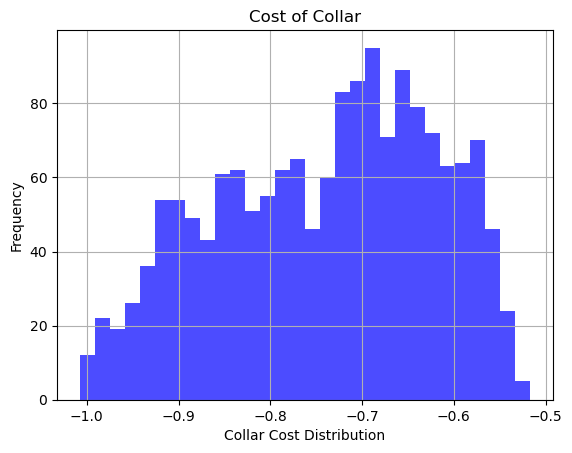

In [3]:
# Plot the distribution of collar strategy cost. Negative cost means the call premium is larger than put premium (i.e. receiving a credit to open)
plot_distribution(env.main_df['collar_cost'], x_label='Collar Cost Distribution', title='Cost of Collar')

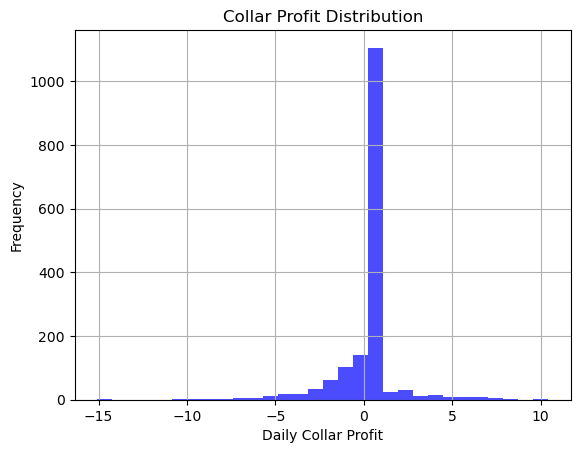

In [6]:
# Plot the distribution collar strategy PnL
plot_distribution(env.main_df['collar_pnl'], x_label='Daily Collar Profit', title='Collar Profit Distribution')

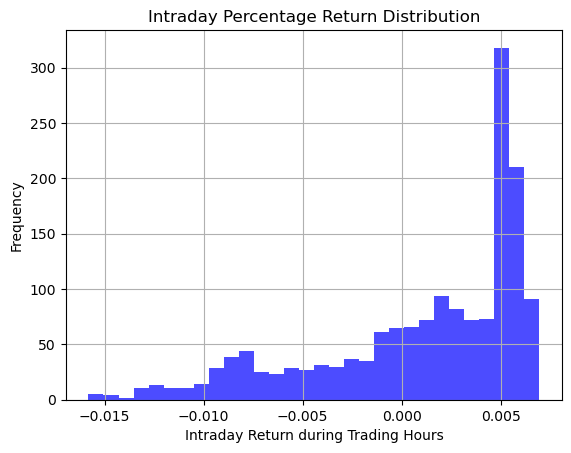

In [7]:
plot_distribution(env.main_df['intraday_return'], x_label='Intraday Return during Trading Hours', title='Intraday Percentage Return Distribution')

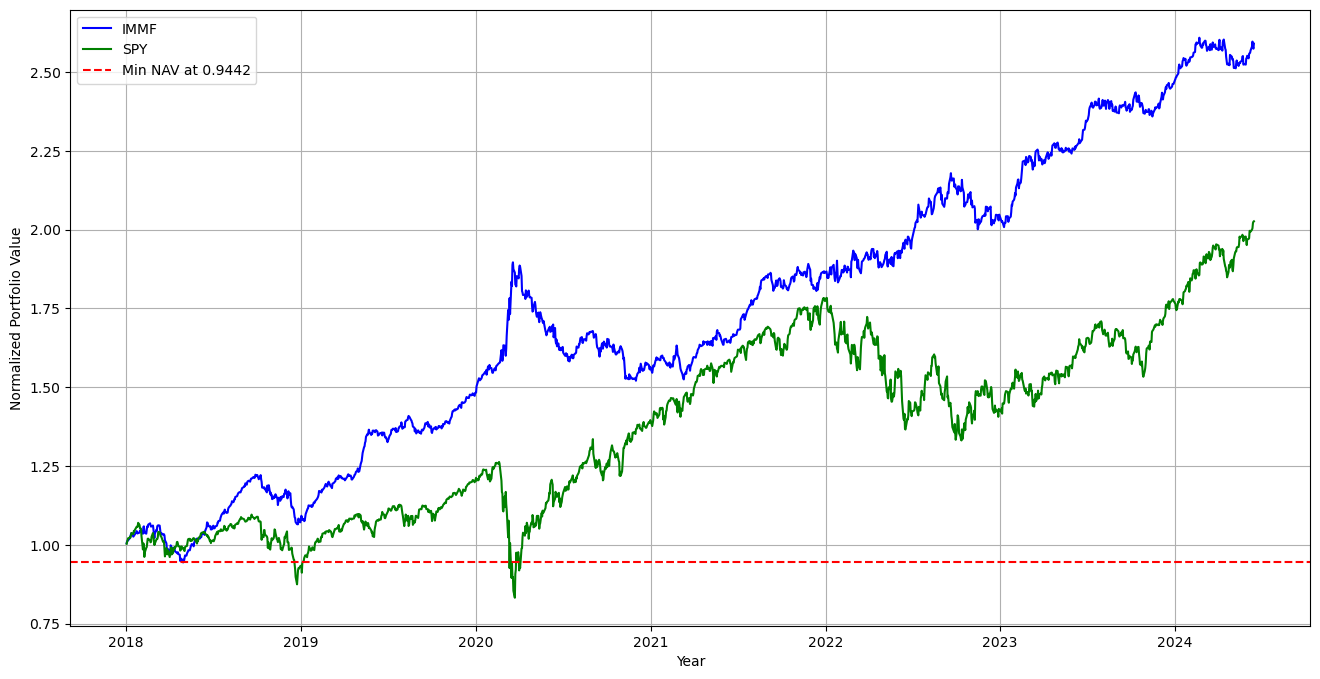

In [4]:
env.update_values_temp_func()
env.plot_nav_vs_spy()

In [5]:
# save the main df in the backtest process to the data folder
env.save_main_df_to_csv(filename='backtest_main_df.csv')